## Initialize VizDoom

In [ ]:
#necessary
!pip install vizdoom
!pip install opencv-python
!pip install pandas

In [1]:
# import VizDoom for game env
from vizdoom import *
# Import random for action sampling
import random
# Import time for sleeping
import time
# import numpy for identity matrix
import numpy as np

from matplotlib import pyplot as plt

## Make it a Gym Env

In [2]:
# Import environment base class from OpenAI Gym
from gymnasium import Env
# Import gym spaces
from gymnasium.spaces import Discrete, Box
# Import Opencv for greyscaling observations
import cv2

LEVEL = 'deadly_corridor'
DOOM_SKILL = 's1'

In [3]:
# Create VizDoom OpenAI Gym Environment
class VizDoomGym(Env): 
    def __init__(self, render=False, config=f'VizDoom/scenarios/{LEVEL}_{DOOM_SKILL}.cfg'):
        """
        Function called when we start the env.
        """

        # Inherit from Env
        super().__init__()
        
        # Set up game
        self.game = DoomGame()
        self.game.load_config(config)
        

        # Whether we want to render the game 
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)

        # Start the game
        self.game.init()
        
        # Create action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(100, 160, 1), dtype=np.uint8)
        self.action_space = Discrete(7)

        # Game variables: HEALTH DAMAGE_TAKEN DAMAGECOUNT SELECTED_WEAPON_AMMO 
        ## We want the change in these variable values, rather than the PiT values
        self.damage_taken = 0
        self.damagecount = 0
        self.ammo = 52

    
    def step(self, action):
        """
        How we take a step in the environment.
        """

        # Specify action and take step
        actions = np.identity(7, dtype=np.uint8)
        # Movement rewards encapsulates predefined reward in the environment config
        movement_reward = self.game.make_action(actions[action], 4) # get action using index -> left, right, shoot

        reward = 0
        # Get all the other stuff we need to return 
        if self.game.get_state():  # if nothing is
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)  # Apply Grayscale
            # ammo = self.game.get_state().game_variables[0] 

            # Reward shaping
            game_variables = self.game.get_state().game_variables # get current PiT game variables
            health, damage_taken, damagecount, ammo = game_variables # unpack

            # calculate change in damage_taken, hitcount, ammo
            damage_taken_delta = -damage_taken + self.damage_taken # disincentivizng us to take damage
            self.damage_taken = damage_taken
            damagecount_delta = damagecount - self.damagecount # increments by +1: incentivizing more hitcounts (1 hitcount = 1 reward)
            self.damagecount = damagecount
            ammo_delta = ammo - self.ammo # increments by -1: disincentiving us to take shots that miss
                                          # hitcount and ammo will cancel each other out
            self.ammo = ammo

            # Pack everything into reward function (tuned weights)
            reward = movement_reward + damage_taken_delta*10 + damagecount_delta*200 + ammo_delta*5
            
            info = ammo
        # If we dont have anything turned from game.get_state
        else:
            # Return a numpy zero array
            state = np.zeros(self.observation_space.shape)
            # Return info (game variables) as zero
            info = 0

        info = {"info":info}
        done = self.game.is_episode_finished()
        truncated = False  # Assuming it's not truncated, modify if applicable
        
        return state, reward, done, truncated, info

    
    def render(self):
        """
        Define how to render the game environment.
        """
        pass

    
    def reset(self, seed=None):
        """
        Function for defining what happens when we start a new game.
        """
        if seed is not None:
            self.game.set_seed(seed)
            
        self.game.new_episode()
        state = self.game.get_state().screen_buffer  # Apply Grayscale

        return self.grayscale(state), {}

    
    def grayscale(self, observation):
        """
        Function to grayscale the game frame and resize it.
        observation: gameframe
        """
        # Change colour channels 
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)

        # Reduce image pixel size for faster training
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize,(100, 160,1))
        return state

    def close(self):
        """
        Call to close down the game.
        """
        self.game.close()

    def run_model(self, observation):
        """
        Run the PyTorch model on the observation to select an action.

        Parameters:
            observation (np.ndarray): The observation from the environment.

        Returns:
            int: The action selected by the model.
        """
        # Preprocess the observation if necessary
        # For example, if your model expects a specific input shape
        
        # Convert observation to torch tensor
        observation = torch.tensor(observation, dtype=torch.float32)[0]
        
        # If necessary, move the observation to the correct device (e.g., GPU)
        # observation = observation.to(device)
        
        # Run the model to get action logits
        with torch.no_grad():
            action_logits = model(observation)  # Assuming batch size of 1
            
        # Select the action with the highest probability
        action = torch.argmax(action_logits).item()
        
        return action

## Custom PPO model

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from torch.distributions import MultivariateNormal

In [6]:

class FeedForwardNN(nn.Module):
    # set up initial neural network
    def __init__(self):
        super(FeedForwardNN, self).__init__()
    
    # define basic neural network layers (can also use convolution layers?)
    def __init__(self, in_dim, out_dim):
        super(FeedForwardNN, self).__init__()

        self.layer1 = nn.Linear(in_dim, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, out_dim)     # 64 IS CHOSEN ARBITRARILY.

    # forward method to pass on neural network
    """
    uses "ReLU" activation function?

    this network module defines both the actor and the critic so will:
    1. take in an observation
    2. return an action OR return a value
    
    - observation is set as parameter
    - network must be a tensor so should convert obs to a tensor first in case it is passed as numpy array
    """

    def forward(self, obs):
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float)      # Convert observation to tensor if it's a numpy array
  
        activation1 = F.relu(self.layer1(obs))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output
    
    


In [7]:
#config
TIMESTEPS_PER_BATCH = 4800
MAX_TIMESTEPS_PER_EPISODE = 1600
GAMMA = 0.95
N_UPDATES_PER_ITERATION = 5
LEARNING_RATE = 0.005

from torch.optim import Adam
#class
class PPO:

    """
    No information regarding input or output sizes, which can change depending on fed environment.

    Solution: initialise it as an instance var in ppo class
    """
    def __init__(self, env):
        # init hyperparameters
        self._init_hyperparameters()
        
        # Extract environment information
        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.act_dim = env.action_space.shape[0]

        # ALG STEP 1
        # Initialize actor and critic networks
        self.actor = FeedForwardNN(self.obs_dim, self.act_dim)
        self.critic = FeedForwardNN(self.obs_dim, 1)


        # Create our variable for the matrix.
        # Note that I chose 0.5 for stdev arbitrarily.
        self.cov_var = torch.full(size=(self.act_dim,), fill_value=0.5)
  
         # Create the covariance matrix
        self.cov_mat = torch.diag(self.cov_var)
        """
        Need to explain what adam is doing in the report:
        The Adam optimizer is an adaptive learning rate optimization algorithm commonly
        used in deep learning that combines the advantages of AdaGrad and RMSprop to compute 
        and apply adaptive learning rates for each parameter during the training process.
        (citations)
        """
        #Initialise optimizer
        self.actor_optim = Adam(self.actor.parameters(), lr=self.lr)
        self.critic_optim = Adam(self.critic.parameters(), lr=self.lr)


    """
    Define a for loop for some number of iterations. 
    ---> Should likely specify how many timesteps to train instead of counting to infinity.
    """
    def learn(self, total_timesteps):
        t_so_far = 0 # Timesteps simulated so far
        while t_so_far < total_timesteps:              # ALG STEP 2
           # ALG STEP 3
            batch_obs, batch_acts, batch_log_probs, batch_rtgs, batch_lens = self.rollout()
            # Calculate how many timesteps we collected this batch   
            t_so_far += np.sum(batch_lens)

            """
            We will use the advantage function defined here:
            https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions

            --> Q^π is the Q-value of state action pair (s, a), and Vᵩₖ is the value of some observation s determined by our critic network following parameters Φ on the k-th iteration.

            Though it is modified: 
            value predicted is following parameters Φ on the k-th iteration, as we'll need to recalculate V(s) following parameters Φ on the i-th epoch.
            """

            # Calculate V_{phi, k}
            V, _ = self.evaluate(batch_obs, batch_acts)
        
            # ALG STEP 5
            # Calculate advantage
            A_k = batch_rtgs - V.detach()  # we do V.detach() since V is a tensor with gradient required.
        
            # Normalize advantages
            A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10) # we add 1e-10 to the standard deviation of the advantages, to avoid the possibility of dividing by 0.
        
            for _ in range(self.n_updates_per_iteration):
                # Calculate V_phi and pi_theta(a_t | s_t)    
                V, curr_log_probs = self.evaluate(batch_obs, batch_acts)

                # Calculate pi_theta(a_t | s_t)
                _, curr_log_probs = self.evaluate(batch_obs, batch_acts)

                # Calculate ratios
                ratios = torch.exp(curr_log_probs - batch_log_probs)

                # Calculate surrogate losses
                surr1 = ratios * A_k
                surr2 = torch.clamp(ratios, 1 - self.clip, 1 + self.clip) * A_k

                # Calculate the actor loss 
                actor_loss = (-torch.min(surr1, surr2)).mean() #taking the minimum between the 2 surrogate losses
                critic_loss = nn.MSELoss()(V, batch_rtgs)      #calculate MSE of predicted values

                # Calculate gradients and perform backward propagation for critic network    
                self.critic_optim.zero_grad()    
                critic_loss.backward()    
                self.critic_optim.step()
                # Calculate gradients and perform backward propagation for actor 
                # network
                self.actor_optim.zero_grad()
                actor_loss.backward()
                self.actor_optim.step()

    """
    need to collect data from a set of episodes by running our current actor policy
    
    ---> Can collect data in batches?

    - To increment t_so_far in learn, the number of timesteps simulated per batch is necessary.
    - Return the lengths of each episode run in our batch for future logging of average episodic length.
    - Optionally, sum the episodic lengths before returning, based on preference.

    Also have to:
    - Determine the number of timesteps to run per batch, which will be treated as a hyperparameter.
    - Create a function named to establish default hyperparameters.
    """
    
    def rollout(self):
        """
        In batch we run episodes til we hit timesteps per batch. 
        Collect the observations, actions, probabilities of actions, rewards, rewards to-go, and lengths of each episode.
        """
        # Batch data
        batch_obs = []             # batch observations           (number of timesteps per batch, dimension of observation)
        batch_acts = []            # batch actions                (number of timesteps per batch, dimension of action)
        batch_log_probs = []       # log probs of each action     (number of timesteps per batch)
        batch_rews = []            # batch rewards                (number of episodes, number of timesteps per episode)
        batch_rtgs = []            # batch rewards-to-go          (number of timesteps per batch)
        batch_lens = []            # episodic lengths in batch    (number of episodes)
        
        # sources explaining why we keep track of raw action probabilities:
        # https://cs.stackexchange.com/questions/70518/why-do-we-use-the-log-in-gradient-based-reinforcement-algorithms
        # https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#deriving-the-simplest-policy-gradient
        # essentially, makes gradient ascient easier
       

        # Number of timesteps run so far this batch
        t = 0 
        while t < self.timesteps_per_batch:
            # Rewards this episode
            ep_rews = []
            obs = self.env.reset()
            done = False
            for ep_t in range(self.max_timesteps_per_episode):
                # Increment timesteps ran this batch so far
                t += 1
                # Collect observation
                batch_obs.append(obs)
                action, log_prob = self.get_action(obs)
                obs, rew, done, _ = self.env.step(action)
  
                # Collect reward, action, and log prob
                ep_rews.append(rew)
                batch_acts.append(action)
                batch_log_probs.append(log_prob)
                if done:
                    break
            # Collect episodic length and rewards
            batch_lens.append(ep_t + 1) # plus 1 because timestep starts at 0
            batch_rews.append(ep_rews) 

        """
        convert our batch_obs, batch_acts, batch_log_probs, and batch_rtgs to tensors since we’ll need them in that form later to draw our computation graphs

        also create some function that will compute the rewards to go of the batch rewards (step 4 of algo)
        """
        # Reshape data as tensors in the shape specified before returning
        batch_obs = torch.tensor(batch_obs, dtype=torch.float)
        batch_acts = torch.tensor(batch_acts, dtype=torch.float)
        batch_log_probs = torch.tensor(batch_log_probs, dtype=torch.float)

        # ALG STEP #4
        batch_rtgs = self.compute_rtgs(batch_rews)
        # Return the batch data
        return batch_obs, batch_acts, batch_log_probs, batch_rtgs, batch_lens
    
    """
    Next we need to get an action.

    This uses MULTIVARIATE NORMAL DISTRIBUTION.
    ---> Essentially, actor will output a "mean" action on a forward pass, then create a covariance matrix with standard deviation.
    ---> Mean is then used to generate a MND and then sample an action close to the mean.
    """
    # source on multivariance normal distribution: https://cs229.stanford.edu/notes2021fall/cs229-notes2.pdf


    # NOTE: actions will be deterministic when testing, meaning that the “mean” action will be our actual action during testing.
    # NOTE: However, during training we need an exploratory factor, which this distribution can help us with.

    def get_action(self, obs):
        # Query the actor network for a mean action.
        # Same thing as calling self.actor.forward(obs)
        mean = self.actor(obs)
        # Create our Multivariate Normal Distribution
        dist = MultivariateNormal(mean, self.cov_mat)
        # Sample an action from the distribution and get its log prob
        action = dist.sample()
        log_prob = dist.log_prob(action)
        
        # Return the sampled action and the log prob of that action
        # Note that I'm calling detach() since the action and log_prob are tensors with computation graphs, so want to get rid of the graph and convert the action to numpy array.
        return action.detach().numpy(), log_prob.detach()
    
    def compute_rtgs(self, batch_rews):
        # The rewards-to-go (rtg) per episode per batch to return.
        # The shape will be (num timesteps per episode)
        batch_rtgs = []
        # Iterate through each episode backwards to maintain same order
        # in batch_rtgs
        for ep_rews in reversed(batch_rews):
            discounted_reward = 0 # The discounted reward so far
            for rew in reversed(ep_rews):
                discounted_reward = rew + discounted_reward * self.gamma
                batch_rtgs.insert(0, discounted_reward)
        # Convert the rewards-to-go into a tensor
        batch_rtgs = torch.tensor(batch_rtgs, dtype=torch.float)
        return batch_rtgs

    

    # default values for hyperparameters. can change in config
    def _init_hyperparameters(self):
        self.timesteps_per_batch = TIMESTEPS_PER_BATCH               # timesteps per batch
        self.max_timesteps_per_episode = MAX_TIMESTEPS_PER_EPISODE   # timesteps per episode
        self.gamma = GAMMA
        self.n_updates_per_iteration = N_UPDATES_PER_ITERATION
        self.clip = 0.2                                              # As recommended by the paper
        self.lr = LEARNING_RATE                                              # As recommended by the paper learning rate

    # function to evaluate V(s)
    def evaluate(self, batch_obs):
        # Query critic network for a value V for each obs in batch_obs.
        V = self.critic(batch_obs).squeeze()
        """
        we perform a squeeze operation here on our returned tensor from a forward pass on our critic network to change the dimensionality of the tensor.

        Since batch_obs retains the shape (timesteps per batch, dimension of observation), 
        the tensor returned from passing batch_obs into our critic network is (timesteps per batch, 1), 
        whereas the shape we want is just (timesteps per batch).
        """

        # Instead of defining a whole new subroutine to calculate log probs, let’s do it in evaluate.

        # Calculate the log probabilities of batch actions using most recent actor network.
        # This segment of code is similar to that in get_action()
        mean = self.actor(batch_obs)
        dist = MultivariateNormal(mean, self.cov_mat)
        log_probs = dist.log_prob(batch_acts)
        # Return predicted values V and log probs log_probs
        return V, log_probs
        

IndentationError: unexpected indent (3884096454.py, line 73)

## Training loop

In [ ]:
env = VizDoomGym(render=True)
model = PPO(env)
model.learn(10000)

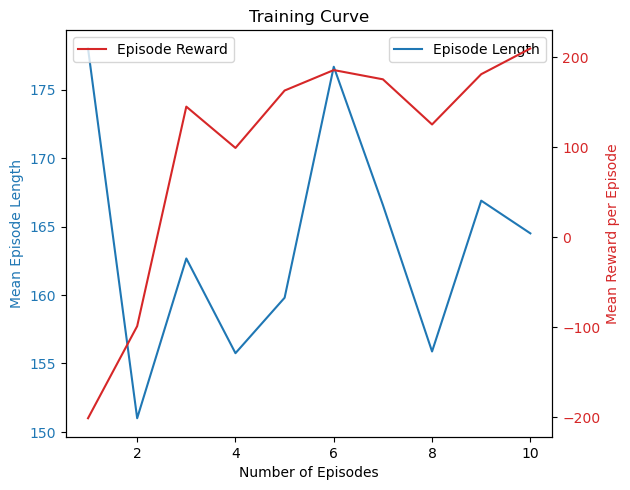

10


ViZDoomUnexpectedExitException: Controlled ViZDoom instance exited unexpectedly.

In [50]:
import os
import pandas as pd
from IPython.display import clear_output
def train(env, model, num_episodes, device, save_dir="./train/train_corridor", save_interval=100):
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    model.to(device)
    gamma = 0.95

    episode_lengths = []
    episode_rewards = []

    checkpoint_episode = []
    checkpoint_avg_rewards = []
    checkpoint_avg_lengths = []

    for episode in range(num_episodes):
        print(episode)
        state = env.reset()
        state_array = np.array(state[0])
        state = torch.from_numpy(state_array).float().unsqueeze(0).permute(0, 3, 1, 2).to(device)
        done = False
        total_reward = 0
        episode_length = 0

        while not done:
            policy_dist, value = model(state)
            action = policy_dist.multinomial(num_samples=1).detach()
            next_state, reward, done, _, _ = env.step(action.item())
            next_state = torch.from_numpy(next_state).float().unsqueeze(0).permute(0, 3, 1, 2).to(device)

            total_reward += reward
            episode_length += 1

            # Calculate and update loss here

            state = next_state

        episode_lengths.append(episode_length)
        episode_rewards.append(total_reward)

        # Save the model every save_interval episodes
        if (episode + 1) % save_interval == 0:
            print(f"Episode {episode + 1}: Completed. Total Reward: {total_reward}")
            
            # Ensure the directory exists before saving the model
            os.makedirs(save_dir, exist_ok=True)
            
            save_path = os.path.join(save_dir, f"model_episode_{episode + 1}.pt")
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at episode {episode + 1} to {save_path}")

            # Calculate running averages of episode length and reward
            avg_episode_lengths = [np.mean(episode_lengths[:i + 1]) for i in range(episode + 1)]
            avg_episode_rewards = [np.mean(episode_rewards[:i + 1]) for i in range(episode + 1)]

            # Save data in checkpoint
            checkpoint_episode.append(episode+1)
            checkpoint_avg_rewards.append(avg_episode_rewards[-1])
            checkpoint_avg_lengths.append(avg_episode_lengths[-1])
            
            # Clear previous output
            clear_output(wait=True)

            # Plotting
            fig, ax1 = plt.subplots()

            ax1.set_xlabel('Number of Episodes')
            ax1.set_ylabel('Mean Episode Length', color='tab:blue')
            ax1.plot(range(1, episode + 2), avg_episode_lengths, color='tab:blue',label='Episode Length')
            ax1.tick_params(axis='y', labelcolor='tab:blue')

            ax2 = ax1.twinx()
            ax2.set_ylabel('Mean Reward per Episode', color='tab:red')
            ax2.plot(range(1, episode + 2), avg_episode_rewards, color='tab:red',label='Episode Reward')
            ax2.tick_params(axis='y', labelcolor='tab:red')

            fig.tight_layout()
            ax1.legend(loc='upper right')
            ax2.legend(loc='upper left')
            plt.title('Training Curve')

            plt.show()

    return pd.DataFrame({
       "Episode": checkpoint_episode,
       "Mean Reward": checkpoint_avg_rewards,
       "Mean Episode Length": checkpoint_avg_lengths
    }) 

if __name__ == "__main__":
    env = VizDoomGym(render=True)
    in_channels = 1  # Assuming grayscale input
    n_actions = env.action_space.n
    gae_lambda = .9
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ActorCriticNetwork(in_channels, n_actions, gae_lambda)
    num_episodes = 10000
    training_data = train(env, model, num_episodes, device)

In [34]:
training_data

,Episode,Mean Reward,Mean Episode Length
